Imports

In [1]:
import sys
sys.path.append("/home/sanketh/DANI/GraphMatching/")

import torch.multiprocessing as mp
mp.set_start_method("spawn")

In [2]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
import itertools
from common.parallel_computation import tqdm_joblib
import random
from tqdm import tqdm
from joblib import Parallel, delayed
from os import cpu_count
import pickle
from livelossplot import PlotLosses
import time
from common.logger import TimeLogging
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from common.graph_data_experiments_utils import *

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!


In [3]:
processes_device_ids = ['cpu'] #[0, 2, 3, 4, 5, 6, 7]

In [4]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
DATA_PATH = '../subgraph_matching_via_nn/data/subcircuits/'

desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [5]:
subgraphs = []
labels = []

subgraphs_for_classification = []

circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
circuit_base_dir = '/home/sanketh/DANI/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
CIRCUIT_DUPLICATES_AMOUNT = 5
REFERENCE_GRAPH_ORIGINAL_LABEL = 1
REFERENCE_GRAPH_ORIGINAL_INDEX = 0

for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    for i in range(CIRCUIT_DUPLICATES_AMOUNT):
        subgraphs_for_classification.append(sub_graph)
        labels.append(0)
for i in range(CIRCUIT_DUPLICATES_AMOUNT):
    labels[REFERENCE_GRAPH_ORIGINAL_INDEX * CIRCUIT_DUPLICATES_AMOUNT + i] = REFERENCE_GRAPH_ORIGINAL_LABEL

zipped_graphs_and_labels = list(zip(subgraphs_for_classification, labels))
random.shuffle(zipped_graphs_and_labels)
unzipped_graphs_and_labels = list(zip(*zipped_graphs_and_labels))
subgraphs_for_classification = unzipped_graphs_and_labels[0]
labels = unzipped_graphs_and_labels[1]

N = len(subgraphs_for_classification)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [6]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

In [7]:
graphs, num_classes = transform_into_s2vgraphs(subgraphs_for_classification, labels, device)

# classes: 2
# maximum node tag: 48
# data: 50


Setup model and training

In [8]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = graphs[:N_training]
test_graphs = graphs[N_training:]

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

In [9]:
liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 20
k_update_plot = 1

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

/home/sanketh/.local/share/virtualenvs/GraphMatching-_Kt3QSDD/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|                                                                                                                         | 0/50 [00:00<?, ?batch/s]/home/sanketh/DANI/GraphMatching/powerful_gnns/models/graphcnn.py:150: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered 

In [10]:
acc_train

NameError: name 'acc_train' is not defined

In [11]:
acc_test

NameError: name 'acc_test' is not defined

Show predictions

In [9]:
model.eval()
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

/home/sanketh/DANI/GraphMatching/powerful_gnns/models/graphcnn.py:150: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  graph_pool = torch.sparse.FloatTensor(idx, elem, torch.Size([len(batch_graph), start_idx[-1]]))


tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


In [10]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


show all distances matrix (margin)

In [11]:
# keep only one instance of each graph
graphs, num_classes = transform_into_s2vgraphs(subgraphs, labels, device)

all_embeddings = model.get_embedding(graphs)

# classes: 1
# maximum node tag: 48
# data: 10


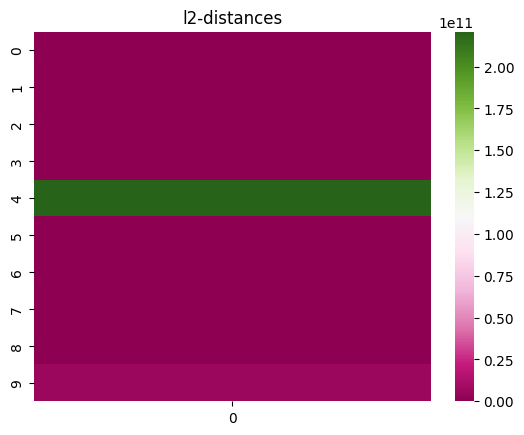

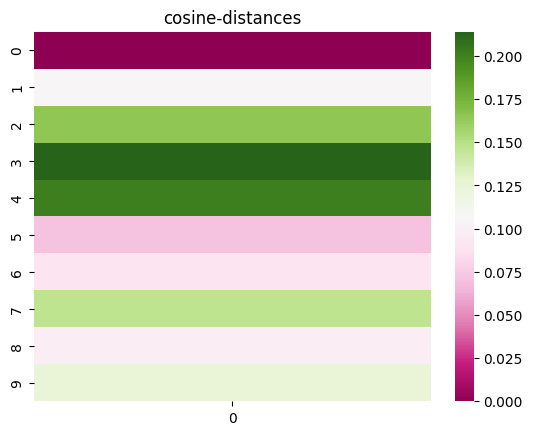

In [12]:
l2_dists = pairwise_l2_distance(all_embeddings)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

rounding_constant = 10 ** 3
cos_dists = (torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant)[REFERENCE_GRAPH_ORIGINAL_INDEX].reshape(-1, 1)

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [13]:
print(get_min_non_diagonal_entry(l2_dists, device, REFERENCE_GRAPH_ORIGINAL_INDEX))
print(get_min_non_diagonal_entry(cos_dists, device, REFERENCE_GRAPH_ORIGINAL_INDEX))

469.466552734375
0.07100000232458115


Contrastive loss training

Assemble graph pairs data

In [14]:
train_samples_list = []
reference_subgraph = subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
negative_examples_subgraphs = subgraphs[:REFERENCE_GRAPH_ORIGINAL_INDEX] + subgraphs[REFERENCE_GRAPH_ORIGINAL_INDEX+1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [15]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

Define graph metric to train, and the trainer

In [16]:
solver_params = {
    "device": device,
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": 50,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 5,
    "max_grad_norm": 0.1,
    "k_update_plot": 1,
    "train_monitoring_epochs_pace": 5,
    "batch_size": len(subgraphs),
    "num_workers": 0,
    "is_use_model_compliation": False, #Only supported for Pytorch > 2.0
    "model_checkpoint_epochs_pace": 10,
}

problem_params = {"input_dim": input_dim}

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

Train

In [ ]:
# show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs], device), model, device)

In [ ]:
trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

In [ ]:
show_distances_heatmap(generate_s2v_graphs([graph.g for graph in graphs], device), model, device)

Add ged=1 examples as positive examples

In [ ]:
# generate subgraphs for which ged(subgraph, reference_subgraph)==1
perturbed_graphs = list(generate_perturbed_graphs(reference_subgraph.G_sub))
for perturbed_graph in perturbed_graphs:
    is_negative_example = False

    G1_annotated = AnnotatedGraph(perturbed_graph)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

In [ ]:
len(train_samples_list)

In [ ]:
val_samples_list = train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = len(train_samples_list)

trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

trainer.train(processes_device_ids=['cpu'], use_existing_data_loaders=False, train_samples_list=train_samples_list, val_samples_list=val_samples_list)

In [ ]:
all_s2v_graphs = generate_s2v_graphs([subgraph.G for subgraph in subgraphs] + perturbed_graphs, device)
# show_distances_heatmap(all_s2v_graphs, model, device)

In [ ]:
show_distances_heatmap(all_s2v_graphs[:len(subgraphs)], model, device)

In [ ]:
reference_s2v_graph = all_s2v_graphs[REFERENCE_GRAPH_ORIGINAL_INDEX]
reference_graph_with_positive_examples = [reference_s2v_graph] + all_s2v_graphs[len(subgraphs):]
reference_graph_with_negative_examples = [all_s2v_graphs[i] for i in range(len(all_s2v_graphs[:len(subgraphs)]))]

In [ ]:
show_distances_heatmap(reference_graph_with_positive_examples, model, device, show_min_off_diagonal=False)

In [ ]:
show_distances_heatmap(reference_graph_with_negative_examples, model, device, show_min_off_diagonal=True)

In [ ]:
_ = graph_metric_nn.eval()

In [ ]:
positive_distances = []
for positive_example_second_graph in reference_graph_with_positive_examples:
    distance = graph_metric_nn.forward([(reference_s2v_graph, positive_example_second_graph)]).item()
    positive_distances.append(distance)
    if distance > solver_params['margin_loss_margin_value']:
        print(f"positive loss term not zero, as distance for this positive example pair is {distance}")

negative_distances = []
for negative_example_second_graph in reference_graph_with_negative_examples:
    if negative_example_second_graph == reference_s2v_graph:
        continue #ignore the same graph with itself
    distance = graph_metric_nn.forward([(reference_s2v_graph, negative_example_second_graph)]).item()
    negative_distances.append(distance)
    if distance < solver_params['margin_loss_margin_value']:
        print(f"negative loss term not zero, as distance for this negative example pair is {distance}")

In [ ]:
max(positive_distances)

In [ ]:
min(negative_distances)

k-subgraphs experiment

In [ ]:
K = 11
full_graph = reference_subgraph.G

subgraphs_iterator = itertools.combinations(full_graph, K)
k_subgraphs = [full_graph.subgraph(s) for s in subgraphs_iterator]
k_subgraph_annotated_graphs = [AnnotatedGraph(g, label=i) for i, g in enumerate(k_subgraphs)]

train_samples_list = []
isomorphic_pairs = []
train_sample_indices_tuple_list = []

In [ ]:
for subgraph_counter1, SG_annotated_1 in enumerate(k_subgraph_annotated_graphs):
    for subgraph_counter2 in range(subgraph_counter1+1, len(k_subgraph_annotated_graphs)):
        SG_annotated_2 = k_subgraph_annotated_graphs[subgraph_counter2]
        train_samples_list.append(compare_graphs_and_generate_pair_example(SG_annotated_1, SG_annotated_2, isomorphic_pairs))
        train_sample_indices_tuple_list.append((subgraph_counter1, subgraph_counter2))
        # if train_samples_list[-1].is_negative_sample == False:
        #     print(f"{subgraph_counter1} vs {subgraph_counter2}")

In [ ]:
used_train_samples_list = train_samples_list[:10_000]

In [ ]:
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 50
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

trainer.train(processes_device_ids=[0], use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [ ]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1704585490.4369323/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

In [ ]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)
plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=20)
plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=20)
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
# ged_pairs_dump_base_path = f".{os.sep}ged_pairs

# loaded_ged_examples = []
# for i, doc_path in enumerate(pathlib.Path(ged_pairs_dump_base_path).rglob("*.p*")):
#     k_subgraph_ged_pairs_list = pickle.load(open(doc_path, 'rb'))
#     loaded_ged_examples += k_subgraph_ged_pairs_list
#     print(i)

# if not os.path.exists(ged_pairs_dump_base_path):
#     os.makedirs(ged_pairs_dump_base_path)
#
# # k_subgraph_to_perturbed_graphs_map = {}
# def generate_ged_paris(subgraph_counter1):
#     train_samples_list = []
#     SG1 = k_subgraph_annotated_graphs[subgraph_counter1]
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1.g))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, AnnotatedGraph(ged1_perturbed_graph), is_negative_example = False))
#
#         ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         for ged2_perturbed_graph in ged2_perturbed_graphs:
#             # could be positive or negative example
#             train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#
#     path = os.path.join(ged_pairs_dump_base_path, f"subgraph_{subgraph_counter1}.p")
#     with open(path, 'wb') as f:
#         pickle.dump(train_samples_list, f)
#     return train_samples_list
#
# total_tasks = len(k_subgraphs)
# with tqdm_joblib(tqdm(desc="My calculation", total=total_tasks)) as progress_bar:
#     #Parallel(n_jobs=16)(delayed(long_task)() for i in range(10))
#
#     ged_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
#         delayed(generate_ged_paris)(subgraph_counter1=subgraph_counter1)
#         for subgraph_counter1 in range(total_tasks)
#     )
#
# # generate subgraphs for which GED==1
# for subgraph_counter1, SG1 in enumerate(k_subgraphs):
#     print(subgraph_counter1)
#     ged1_perturbed_graphs = list(generate_perturbed_graphs(SG1))
#     for ged1_perturbed_graph in ged1_perturbed_graphs:
#         # positive example
#         train_samples_list.append(generate_pair_example(SG1, ged1_perturbed_graph, is_negative_example = False))
#         #
#         # ged2_perturbed_graphs = list(generate_perturbed_graphs(ged1_perturbed_graph))
#         # for ged2_perturbed_graph in ged2_perturbed_graphs:
#         #     # could be positive or negative example
#         #     train_samples_list.append(compare_graphs_and_generate_pair_example(k_subgraph_annotated_graphs[subgraph_counter1], AnnotatedGraph(ged2_perturbed_graph)))
#     # k_subgraph_to_perturbed_graphs_map[SG1] = perturbed_graphs

#
#
# # generate all pairs examples
# for SG1, SG1_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#     for SG2, SG2_perturbed_graphs in k_subgraph_to_perturbed_graphs_map.items():
#
#         if SG1 == SG2:
#             continue # trivial pairs, or pairs already considered
#
#         for SG2_perturbed_graph in SG2_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1, SG2_perturbed_graph))
#
#         for SG1_perturbed_graph in SG1_perturbed_graphs:
#             train_samples_list.append(compare_graphs_and_generate_pair_example(SG1_perturbed_graph, SG2))

In [ ]:
random_k_subgraphs = generate_k_subgraph(reference_subgraph, k=9)

In [ ]:
len(random_k_subgraphs)

In [ ]:
POSITIVE_EXAMPLES_GED_DIST_pairs_n = 20 #2000
POSITIVE_EXAMPLES_GED_DIST = 1
POSITIVE_EXAMPLES_k_subgraphs = random_k_subgraphs

NEGATIVE_EXAMPLES_GED_DIST_pairs_n = 20
NEGATIVE_EXAMPLES_GED_DIST = 4 #4
NEGATIVE_EXAMPLES_k_subgraphs = random_k_subgraphs#[:20]

ged_examples1, ged_examples2 = generate_positive_and_negative_ged_pairs(POSITIVE_EXAMPLES_k_subgraphs, POSITIVE_EXAMPLES_GED_DIST, POSITIVE_EXAMPLES_GED_DIST_pairs_n, NEGATIVE_EXAMPLES_k_subgraphs, NEGATIVE_EXAMPLES_GED_DIST, NEGATIVE_EXAMPLES_GED_DIST_pairs_n)

ged_examples = ged_examples1 + ged_examples2
random.shuffle(ged_examples)

train_ratio = 0.7
train_ged_examples_amount = int(len(ged_examples) * train_ratio)
train_ged_examples = ged_examples[:train_ged_examples_amount]
eval_ged_examples = ged_examples[train_ged_examples_amount:]

In [ ]:
len(train_ged_examples)

In [ ]:
len(ged_examples2)

In [ ]:
len(ged_examples1)

In [ ]:
for k_subgraph in k_subgraphs:
    if k_subgraphs[0].nodes == k_subgraph.nodes:
        print("yes")

In [ ]:
len(k_subgraphs)

In [ ]:
len(train_ged_examples)

check 1-WL distance

In [ ]:
# optimized single call for WL distance calculation
### NOTE: Wl dist is not stable (depends which batch of graph you applied it with) ###
# wl_dist_matrix = get_graph_wl_distances(k_subgraphs, node_label=False)

# negative_pairs_wl_distances = []
# positive_pairs_wl_distances = []
#
# positive_pairs_index_to_dist_map = {}
# negative_pairs_index_to_dist_map = {}
#
# for i, train_sample in enumerate(train_samples_list):
#     is_negative_sample = train_sample.is_negative_sample
#     graph1 = train_sample.subgraph
#     graph2 = train_sample.masked_graph
#
#     # s2v_graphs = generate_s2v_graphs([graph1.g, graph2.g], device, print_stats=False)
#
#     # distance = graph_metric_nn.forward([(s2v_graphs[0], s2v_graphs[1])]).item()
#
#     # wl_dist = get_graph_wl_distances([graph1.g, graph2.g], node_label=False)[0][1]
#
#     graph1_index, graph2_index = train_sample_indices_tuple_list[i]
#     wl_dist = wl_dist_matrix[graph1_index][graph2_index]
#     wl_dist = round(wl_dist, 6)
#
#     if is_negative_sample:
#         negative_pairs_wl_distances.append(wl_dist)
#         negative_pairs_index_to_dist_map[i] = wl_dist
#     else:
#         positive_pairs_wl_distances.append(wl_dist)
#         positive_pairs_index_to_dist_map[i] = wl_dist

In [ ]:
# _, _ = show_wl_dist_histograms(ged_1_examples, ged_2_examples, max_examples_amount = 1_000)

In [ ]:
# margin = 0.001
# calc_margin_loss(torch.tensor(positive_pairs_wl_distances+negative_pairs_wl_distances), torch.cat((torch.ones(len(positive_pairs_wl_distances)), torch.zeros(len(negative_pairs_wl_distances)))), margin)

Fit GNN on k subgraph GED pairs

In [ ]:
# disable debugging overhead operations
torch.autograd.set_detect_anomaly(mode=False)

In [ ]:
solver_params['margin_loss_margin_value'] = 0.5 #0.25 #0.01

In [ ]:
# used_train_samples_amount = 50_000
used_train_samples_list = train_ged_examples#[:used_train_samples_amount] #Needed due to performance issues

In [ ]:
len(used_train_samples_list)

In [ ]:
last_checkpoint_model_path = None

# val_samples_list = used_train_samples_list
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=128, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8 #32 #2048 #1024 #512
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200 #480--
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=last_checkpoint_model_path)

# trainer.set_existing_data_loader_paths(
#     ['./dataloaders/1702148493.0283618.p',
#  './dataloaders/1702148497.9922142.p',
#  './dataloaders/1702148502.9499629.p',
#  './dataloaders/1702148511.1819935.p'],
# []
# )

In [ ]:
trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])

In [ ]:
# GED2 -> "./mp/1703271648.8009052/best_model_state_dict.pt", not seperable well
# GED4 - > ""./mp/1703279923.1549501/best_model_state_dict.pt", seperable well (not perfect but close)

In [ ]:
trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1703411975.73806/best_model_state_dict.pt")
_ = graph_metric_nn.eval()

In [ ]:
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, used_train_samples_list)

In [ ]:
len(train_negative_distances) / len(train_positive_distances)

In [ ]:
plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=1)

In [ ]:
plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=10)

In [ ]:
calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

Train again without rebuilding data loaders, and without the val_loader

In [ ]:
# model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
# new_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params)

# new_trainer.previous_train_loader_paths = trainer.previous_train_loader_paths
# new_trainer.previous_val_loader_paths = [None for device_id in processes_device_ids] #trainer.previous_val_loader_paths
# new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, used_train_samples_list, train_positive_distances, train_negative_distances, solver_params, device)

Generalization error

In [ ]:
eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, graph_metric_nn, eval_ged_examples)

In [ ]:
plot_histogram(eval_positive_distances, "eval positive examples", max_range=10)

In [ ]:
plot_histogram(eval_negative_distances, "eval negative examples", max_range=10)

In [ ]:
calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
_, _ = calc_performance_metrics(graph_metric_nn, eval_ged_examples, eval_positive_distances, eval_negative_distances, solver_params, device)

Execution time profiling

In [ ]:
# from cProfile import Profile
# from pstats import SortKey, Stats

# with Profile() as profile:
#     new_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=True)
#     (
#     Stats(profile)
#         .strip_dirs()
#         .sort_stats(SortKey.CUMULATIVE)
#         .print_stats()
#     )

## save used_train_samples_list

In [ ]:
ref_graphs_with_negative_eaxmples = set([annotated_graph.label for annotated_graph in NEGATIVE_EXAMPLES_k_subgraphs])
ref_graphs_with_positive_eaxmples = set([annotated_graph.label for annotated_graph in POSITIVE_EXAMPLES_k_subgraphs])
reg_graphs_with_negative_and_positive_examples = ref_graphs_with_negative_eaxmples.intersection(ref_graphs_with_positive_eaxmples)

reference_graph_to_pairs_for_training_list_map = {}

for pair in used_train_samples_list:
    ref_graph = pair.subgraph
    ref_graph_label = pair.subgraph.label

    if ref_graph_label not in reg_graphs_with_negative_and_positive_examples:
        continue
    
    paired_graph = pair.masked_graph

    lst = []
    if ref_graph_label in reference_graph_to_pairs_for_training_list_map:
        lst = reference_graph_to_pairs_for_training_list_map[ref_graph_label]
    lst.append(pair)
    reference_graph_to_pairs_for_training_list_map[ref_graph_label] = lst

In [ ]:
dump_base_path = f".{os.sep}ged_train_subset"
if not os.path.exists(dump_base_path):
    os.makedirs(dump_base_path)

dump_path = os.path.join(dump_base_path, f"{str(time.time())}.p")
with open(dump_path, 'wb') as f:
    pickle.dump(reference_graph_to_pairs_for_training_list_map, f)

In [ ]:
p_ctr = 0
n_ctr = 0
for k, v in reference_graph_to_pairs_for_training_list_map.items():
    for example in v:
        if example.is_negative_sample:
            n_ctr += 1
        else:
            p_ctr += 1

In [ ]:
p_ctr

In [ ]:
n_ctr

Capacity test

In [ ]:
hidden_dim = 16
num_layers = 5
num_mlp_layers = 2
model_factory_func = lambda device: GraphCNN(num_layers=num_layers, num_mlp_layers = num_mlp_layers, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8
solver_params["k_update_plot"] = 10
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200
current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path="./mp/1705969912.0095499/best_model_state_dict.pt")

In [ ]:
trainer = None
hid_dim_to_val_loss_map = {}
for hid_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(used_train_samples_list, solver_params, problem_params, processes_device_ids, hidden_dim=hid_dim, trainer=trainer)
    hid_dim_to_val_loss_map[hid_dim] = best_val_loss
    print(f"{hid_dim}: {best_val_loss}")

In [ ]:
print(hid_dim_to_val_loss_map)
plot_map(hid_dim_to_val_loss_map, "hidden_dim", "val loss", "model performance vs model capacity")

Expressivity test

In [ ]:
positive_GED_k_to_negative_GED_k_to_val_loss_map = {}
pairs_n = 800
positive_examples_k_subgraphs = random_k_subgraphs[:20]
ged_positive_examples_cache_map = {}
ged_negative_examples_cache_map = {}

for positive_GED_k in [2, 3, 4, 5, 6, 7]:
    negative_GED_k_to_val_loss_map = {}
    positive_GED_k_to_negative_GED_k_to_val_loss_map[positive_GED_k] = negative_GED_k_to_val_loss_map

    # prepare positive pairs dataset
    with tqdm_joblib(tqdm(desc="My calculation", total=len(positive_examples_k_subgraphs))) as progress_bar:
        ged_positive_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
            delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=positive_GED_k, pairs_n=pairs_n, is_negative_example=False, force_exactly_pairs_n=False)
            for annotated_subgraph in positive_examples_k_subgraphs
        )
    ged_positive_examples = [elem for lst in ged_positive_examples for elem in lst]
    ged_positive_examples_cache_map[positive_GED_k] = ged_positive_examples
    print(f"#pos examples = {len(ged_positive_examples)}")

    for negative_GED_k in range(positive_GED_k + 1, 9):
        print(f"expressivity test for positive_GED_k={positive_GED_k} & negative_GED_k={negative_GED_k}")

        if negative_GED_k in ged_negative_examples_cache_map:
            ged_negative_examples = ged_negative_examples_cache_map[negative_GED_k]
        else:

            # prepare negative pairs dataset
            with tqdm_joblib(tqdm(desc="My calculation", total=len(NEGATIVE_EXAMPLES_k_subgraphs))) as progress_bar:
                ged_negative_examples = Parallel(n_jobs=int(cpu_count()), prefer='processes')(
                    delayed(generate_random_ged_paris)(annotated_subgraph=annotated_subgraph, ged_dist=negative_GED_k, pairs_n=pairs_n, is_negative_example=True, force_exactly_pairs_n=False)
                    for annotated_subgraph in NEGATIVE_EXAMPLES_k_subgraphs
                )

            ged_negative_examples = [elem for lst in ged_negative_examples for elem in lst]
            ged_negative_examples_cache_map[negative_GED_k] = ged_negative_examples
        print(f"#neg examples = {len(ged_negative_examples)}")

        # combine examples to one dataset
        ged_examples = ged_positive_examples + ged_negative_examples
        random.shuffle(ged_examples)

        train_ratio = 0.7
        train_ged_examples_amount = int(len(ged_examples) * train_ratio)
        train_ged_examples = ged_examples[:train_ged_examples_amount]
        eval_ged_examples = ged_examples[train_ged_examples_amount:]

        print(f"#train set examples = {len(train_ged_examples)}")

        # train
        trainer, graph_metric_nn, best_val_loss = train_model_with_hyperparams(train_ged_examples, solver_params, problem_params, processes_device_ids, hidden_dim=64, trainer=None)
        negative_GED_k_to_val_loss_map[negative_GED_k] = best_val_loss
        print(f"negative K={negative_GED_k}: val_loss={best_val_loss}")

        # more performance metrics
        _ = graph_metric_nn.eval()

        train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, train_ged_examples)
        _, _ = calc_performance_metrics(graph_metric_nn, train_ged_examples, train_positive_distances, train_negative_distances, solver_params, device)

        eval_positive_distances, eval_negative_distances = get_examples_distances(trainer, graph_metric_nn, eval_ged_examples)
        _, _ = calc_performance_metrics(graph_metric_nn, eval_ged_examples, eval_positive_distances, eval_negative_distances, solver_params, device)
        calc_margin_loss(torch.tensor(eval_positive_distances+eval_negative_distances), torch.cat((torch.ones(len(eval_positive_distances)), torch.zeros(len(eval_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

        plot_histogram(train_positive_distances, "train positive examples", min_range=0, max_range=2)
        plot_histogram(train_negative_distances, "train negative examples", min_range=0, max_range=2)
        plot_histogram(eval_positive_distances, "eval positive examples", min_range=0, max_range=2)
        plot_histogram(eval_negative_distances, "eval negative examples", min_range=0, max_range=2)

In [ ]:
GED_experiments_map = {}
for positive_GED_k, negative_GED_k_to_val_loss_map in positive_GED_k_to_negative_GED_k_to_val_loss_map.items():
    for negative_GED_k, val_loss in negative_GED_k_to_val_loss_map.items():
        GED_experiments_map[f"{positive_GED_k}_{negative_GED_k}"] = val_loss

chart_bar_plot(GED_experiments_map, "positive-GED-K_negative-GED-K", "validation loss", "model expressivity analysis")

test of 2D features space to illustrate the GED - apply MDS to separate the pairs (show the separation of the two areas) show we get a smooth wrap function using a higher dimensional embedding

In [ ]:
# choose reference graph s.
reference_graph_for_GED_visualization = random_k_subgraphs[0]

# generate 50 s+GED-1 graphs for positive examples (remember label)
# generate 50 s+GED-4 graphs for negative examples (remember label)
negative_ged_pairs, positive_ged_pairs = create_ged_visulaization_graphs(reference_graph_for_GED_visualization, label_class_examples_amount=500, positive_GED=3, negative_GED=6)

In [ ]:
# load trained pairs, and visualize some reference graphs and their pairs
trained_pairs_path = f".{os.sep}ged_train_subset{os.sep}1705968201.9176743.p"
trained_pairs_map = pickle.load(open(trained_pairs_path, 'rb'))

In [ ]:
ctr = 0
for ref_graph_label, ref_graph_pairs in trained_pairs_map.items():
    if len(ref_graph_pairs) > 35:
        neg_pairs_ctr = 0
        for pair in ref_graph_pairs:
            if pair.is_negative_sample:
                neg_pairs_ctr += 1
        print(f"reference graph label: {ref_graph_label}, negative pairs amount = {neg_pairs_ctr}")
        ctr += 1

print(ctr)

In [ ]:
def visualize_embeddings_for_trained_model(ref_graph, positive_pairs, negative_pairs, solver_params, problem_params, input_dim, num_classes):
    for hidden_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
        print(hidden_dim)
        model_dump_path = get_model_dump_path(hidden_dim)

        model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

        _, graph_metric_nn, _ = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=model_dump_path)

        # calc embeddings of all pairs, apply MDS and plot
        visualize_embeddings(graph_metric_nn, ref_graph, positive_pairs, negative_pairs, device=device)

In [ ]:
selected_train_reference_graph_pairs = trained_pairs_map[1799]
selected_train_reference_graph = selected_train_reference_graph_pairs[0].subgraph
selected_train_reference_graph_positive_pairs = [pair for pair in selected_train_reference_graph_pairs if pair.is_negative_sample == False]
selected_train_reference_graph_negative_pairs = [pair for pair in selected_train_reference_graph_pairs if pair.is_negative_sample == True]

visualize_embeddings_for_trained_model(selected_train_reference_graph, selected_train_reference_graph_positive_pairs, selected_train_reference_graph_negative_pairs, solver_params, problem_params, input_dim=1, num_classes=1, device=device)

In [ ]:
visualize_embeddings_for_trained_model(reference_graph_for_GED_visualization, positive_ged_pairs, negative_ged_pairs, solver_params, problem_params, input_dim=1, num_classes=1, device=device)

In [ ]:
gt_labels = [0] + [0 for pair in positive_ged_pairs] + [1 for pair in negative_ged_pairs]
hid_dim_to_clustering_score_maps_map = {}

for hidden_dim in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    model_dump_path = get_model_dump_path(hidden_dim)
    model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=1, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)

    _, graph_metric_nn, _ = init_embedding_net_and_trainer(model_factory_func, model_dump_path)

    # calc embeddings of all pairs
    all_embeddings = get_embeddings(graph_metric_nn, reference_graph_for_GED_visualization, positive_ged_pairs, negative_ged_pairs)\
    .detach().cpu().numpy()

    # cluster and measure clustering quality
    hid_dim_to_clustering_score_maps_map[hidden_dim] = measure_clustering(all_embeddings, gt_labels)

In [ ]:
hid_dim_to_clustering_score_maps_map

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'sil', 'silhouette')

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'dav', 'davies-bouldin')

In [ ]:
show_score_plot(hid_dim_to_clustering_score_maps_map, 'nmi', 'nmi')

In [ ]:
# metric vs GED 3D plot
# 	for the X and Y, use radius-s of GED, e.g. for radius =1, all GED-1 examples (against a fixed reference graph)

# interactive mode may cause issues, see: https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab

%matplotlib notebook

In [ ]:
#TODO:
# 	what about the sampled graphs in the space, are they random? or they are sampled real subgraphs from the full graph?
# 		allow both configurations:
# 			all GED
# 			just existing sampled subgraphs GED (we can color them among all GED actually)

In [ ]:
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[10], GED_dists = [1, 4], max_samples_per_radius = 50)

In [ ]:
multiple_ged_radiuses_graphs_map = visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[15], GED_dists = [1, 4, 9], max_samples_per_radius = 500)

In [ ]:
multiple_ged_radiuses_graphs_map = visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, random_k_subgraphs[15], GED_dists = [1, 4, 9], max_samples_per_radius = 500)

In [ ]:
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, reference_graph_for_GED_visualization, GED_dists = [3, 6], max_samples_per_radius = 50)

In [ ]:
train_ged_dist_to_pairs_map = {1: selected_train_reference_graph_positive_pairs, 4: selected_train_reference_graph_negative_pairs}
visualize_reference_graph_model_loss_space(solver_params, problem_params, 1024, selected_train_reference_graph, GED_dists = train_ged_dist_to_pairs_map, max_samples_per_radius = 50)

In [ ]:
train_positive_distances, train_negative_distances = calc_margin_loss_for_pairs(trainer, graph_metric_nn, solver_params, selected_train_reference_graph_positive_pairs + selected_train_reference_graph_negative_pairs)

In [ ]:
max(train_positive_distances)

In [ ]:
min(train_negative_distances)

In [ ]:
trainer, graph_metric_nn = create_metric_and_trainer(hidden_dim=1024, solver_params=solver_params, problem_params=problem_params)
_ = graph_metric_nn.eval()
epoch_val_loss = 0
val_samples_list = positive_ged_pairs + negative_ged_pairs
stub_train_samples_list = val_samples_list[:1]
train_loaders, val_loaders = trainer.get_data_loaders(stub_train_samples_list, val_samples_list, 0, ['cpu'])
val_loader = val_loaders[0]

for val_batch in val_loader:
    val_loss = trainer.calculate_loss_for_batch(val_batch, is_train=False)
    epoch_val_loss += val_loss.item()

In [ ]:
epoch_val_loss

In [ ]:
# all_train_reference_graph_pairs = [pair for _, train_reference_graph_pairs in trained_pairs_map.items() for pair in train_reference_graph_pairs]
train_positive_distances, train_negative_distances = get_examples_distances(trainer, graph_metric_nn, ged_examples1 + ged_examples2)

calc_margin_loss(torch.tensor(train_positive_distances+train_negative_distances), torch.cat((torch.ones(len(train_positive_distances)), torch.zeros(len(train_negative_distances)))), margin = solver_params['margin_loss_margin_value'])

In [ ]:
plot_histogram(train_positive_distances, "positive pair distances", min_range=0, max_range=1)
plot_histogram(train_negative_distances, "negative pair distances", min_range=0, max_range=7)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 1, multiple_ged_radiuses_graphs_map[1])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4], max_range=0.2)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4], max_range=1)

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 4, multiple_ged_radiuses_graphs_map[4])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 9, multiple_ged_radiuses_graphs_map[9])

In [ ]:
plot_histogram_for_ged_pairs(trainer, graph_metric_nn, 9, multiple_ged_radiuses_graphs_map[9], max_range=3)

In [ ]:
# plt.close('all')

# Brute force training

In [18]:
brute_force_k_subgraph_annotated_graphs, G_perturbed, G_sub = generate_pairs_data_set(circuit_base_dir=circuit_base_dir, circuit_file_name = 'comp1_2')

enter generate_pairs_data_set
full graph has 16 nodes, subgraph has 8 nodes, removing 4 non subgraph nodes from full graph
starting generating subgraphs
start generate_k_subgraphs
enter generate_k_subgraphs
total time for finished all_connected_subgraphs (total of 420 graphs):0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #4 finished, chunk size=5:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #73 finished, chunk size=5:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #5 finished, chunk size=5:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #8 finished, chunk size=5:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #30 finished, chunk size=5:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #43 finished, chunk size=5:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #12 finished, chunk size=5:0s
enter generate_k_subgraphs_for_chunk
total time for Chunk #13 finished, chunk size=5:0s
enter generate_k_su

Pairs dataset construction:   1%|█                                                                                       | 1/88 [00:09<14:19,  9.88s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #0 of 2085 pairs


Pairs dataset construction:   2%|██                                                                                      | 2/88 [00:15<10:20,  7.21s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #1 of 2060 pairs


Pairs dataset construction:   3%|███                                                                                     | 3/88 [00:20<08:59,  6.34s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #2 of 2035 pairs


Pairs dataset construction:   5%|████                                                                                    | 4/88 [00:25<08:14,  5.88s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #3 of 2010 pairs


Pairs dataset construction:   6%|█████                                                                                   | 5/88 [00:31<07:54,  5.71s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #4 of 1985 pairs


Pairs dataset construction:   7%|██████                                                                                  | 6/88 [00:36<07:46,  5.69s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #5 of 1960 pairs


Pairs dataset construction:   8%|███████                                                                                 | 7/88 [00:42<07:36,  5.63s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #6 of 1935 pairs


Pairs dataset construction:   9%|████████                                                                                | 8/88 [00:47<07:26,  5.58s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #7 of 1910 pairs


Pairs dataset construction:  10%|█████████                                                                               | 9/88 [00:53<07:26,  5.66s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #8 of 1885 pairs


Pairs dataset construction:  11%|█████████▉                                                                             | 10/88 [00:59<07:19,  5.63s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #9 of 1860 pairs


Pairs dataset construction:  12%|██████████▉                                                                            | 11/88 [01:04<06:59,  5.44s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #10 of 1835 pairs


Pairs dataset construction:  14%|███████████▊                                                                           | 12/88 [01:09<06:58,  5.51s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #11 of 1810 pairs


Pairs dataset construction:  15%|████████████▊                                                                          | 13/88 [01:15<06:45,  5.41s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #12 of 1785 pairs


Pairs dataset construction:  16%|█████████████▊                                                                         | 14/88 [01:19<06:22,  5.17s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #13 of 1760 pairs


Pairs dataset construction:  17%|██████████████▊                                                                        | 15/88 [01:24<06:20,  5.21s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #14 of 1735 pairs


Pairs dataset construction:  18%|███████████████▊                                                                       | 16/88 [01:30<06:18,  5.26s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #15 of 1710 pairs


Pairs dataset construction:  19%|████████████████▊                                                                      | 17/88 [01:35<06:05,  5.15s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #16 of 1685 pairs


Pairs dataset construction:  20%|█████████████████▊                                                                     | 18/88 [01:40<06:10,  5.30s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #17 of 1660 pairs


Pairs dataset construction:  22%|██████████████████▊                                                                    | 19/88 [01:46<06:04,  5.28s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #18 of 1635 pairs


Pairs dataset construction:  23%|███████████████████▊                                                                   | 20/88 [01:51<06:09,  5.43s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #19 of 1610 pairs


Pairs dataset construction:  24%|████████████████████▊                                                                  | 21/88 [01:57<06:09,  5.51s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #20 of 1585 pairs


Pairs dataset construction:  25%|█████████████████████▊                                                                 | 22/88 [02:03<06:08,  5.59s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #21 of 1560 pairs


Pairs dataset construction:  26%|██████████████████████▋                                                                | 23/88 [02:08<05:54,  5.45s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #22 of 1535 pairs


Pairs dataset construction:  27%|███████████████████████▋                                                               | 24/88 [02:13<05:50,  5.47s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #23 of 1510 pairs


Pairs dataset construction:  28%|████████████████████████▋                                                              | 25/88 [02:19<05:40,  5.40s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #24 of 1485 pairs


Pairs dataset construction:  30%|█████████████████████████▋                                                             | 26/88 [02:24<05:37,  5.45s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #25 of 1460 pairs


Pairs dataset construction:  31%|██████████████████████████▋                                                            | 27/88 [02:30<05:30,  5.42s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #26 of 1435 pairs


Pairs dataset construction:  32%|███████████████████████████▋                                                           | 28/88 [02:35<05:18,  5.31s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #27 of 1410 pairs


Pairs dataset construction:  33%|████████████████████████████▋                                                          | 29/88 [02:40<05:19,  5.41s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #28 of 1385 pairs


Pairs dataset construction:  34%|█████████████████████████████▋                                                         | 30/88 [02:46<05:09,  5.34s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #29 of 1360 pairs


Pairs dataset construction:  35%|██████████████████████████████▋                                                        | 31/88 [02:51<05:12,  5.48s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #30 of 1335 pairs


Pairs dataset construction:  36%|███████████████████████████████▋                                                       | 32/88 [02:56<05:01,  5.38s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #31 of 1310 pairs


Pairs dataset construction:  38%|████████████████████████████████▋                                                      | 33/88 [03:02<05:00,  5.47s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #32 of 1285 pairs


Pairs dataset construction:  39%|█████████████████████████████████▌                                                     | 34/88 [03:08<04:58,  5.52s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #33 of 1260 pairs


Pairs dataset construction:  40%|██████████████████████████████████▌                                                    | 35/88 [03:13<04:47,  5.43s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #34 of 1235 pairs


Pairs dataset construction:  41%|███████████████████████████████████▌                                                   | 36/88 [03:19<04:48,  5.55s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #35 of 1210 pairs


Pairs dataset construction:  42%|████████████████████████████████████▌                                                  | 37/88 [03:24<04:37,  5.45s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #36 of 1185 pairs


Pairs dataset construction:  43%|█████████████████████████████████████▌                                                 | 38/88 [03:29<04:31,  5.44s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #37 of 1160 pairs


Pairs dataset construction:  44%|██████████████████████████████████████▌                                                | 39/88 [03:34<04:20,  5.32s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #38 of 1135 pairs


Pairs dataset construction:  45%|███████████████████████████████████████▌                                               | 40/88 [03:40<04:20,  5.43s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #39 of 1110 pairs


Pairs dataset construction:  47%|████████████████████████████████████████▌                                              | 41/88 [03:45<04:12,  5.37s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #40 of 1085 pairs


Pairs dataset construction:  48%|█████████████████████████████████████████▌                                             | 42/88 [03:51<04:05,  5.35s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #41 of 1060 pairs


Pairs dataset construction:  49%|██████████████████████████████████████████▌                                            | 43/88 [03:56<04:03,  5.42s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #42 of 1035 pairs


Pairs dataset construction:  50%|███████████████████████████████████████████▌                                           | 44/88 [04:02<03:59,  5.45s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #43 of 1010 pairs


Pairs dataset construction:  51%|████████████████████████████████████████████▍                                          | 45/88 [04:07<03:56,  5.50s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #44 of 985 pairs


Pairs dataset construction:  52%|█████████████████████████████████████████████▍                                         | 46/88 [04:13<03:54,  5.58s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #45 of 960 pairs


Pairs dataset construction:  53%|██████████████████████████████████████████████▍                                        | 47/88 [04:19<03:45,  5.50s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #46 of 935 pairs


Pairs dataset construction:  55%|███████████████████████████████████████████████▍                                       | 48/88 [04:24<03:39,  5.49s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #47 of 910 pairs


Pairs dataset construction:  56%|████████████████████████████████████████████████▍                                      | 49/88 [04:30<03:36,  5.55s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #48 of 885 pairs


Pairs dataset construction:  57%|█████████████████████████████████████████████████▍                                     | 50/88 [04:35<03:29,  5.52s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #49 of 860 pairs


Pairs dataset construction:  58%|██████████████████████████████████████████████████▍                                    | 51/88 [04:41<03:25,  5.55s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #50 of 835 pairs


Pairs dataset construction:  59%|███████████████████████████████████████████████████▍                                   | 52/88 [04:46<03:22,  5.62s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #51 of 810 pairs


Pairs dataset construction:  60%|████████████████████████████████████████████████████▍                                  | 53/88 [04:52<03:18,  5.67s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #52 of 785 pairs


Pairs dataset construction:  61%|█████████████████████████████████████████████████████▍                                 | 54/88 [04:58<03:11,  5.64s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #53 of 760 pairs


Pairs dataset construction:  62%|██████████████████████████████████████████████████████▍                                | 55/88 [05:03<03:02,  5.52s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #54 of 735 pairs


Pairs dataset construction:  64%|███████████████████████████████████████████████████████▎                               | 56/88 [05:09<02:57,  5.55s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #55 of 710 pairs


Pairs dataset construction:  65%|████████████████████████████████████████████████████████▎                              | 57/88 [05:14<02:48,  5.44s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #56 of 685 pairs


Pairs dataset construction:  66%|█████████████████████████████████████████████████████████▎                             | 58/88 [05:19<02:40,  5.35s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #57 of 660 pairs


Pairs dataset construction:  67%|██████████████████████████████████████████████████████████▎                            | 59/88 [05:25<02:36,  5.40s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #58 of 635 pairs


Pairs dataset construction:  68%|███████████████████████████████████████████████████████████▎                           | 60/88 [05:30<02:30,  5.38s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #59 of 610 pairs


Pairs dataset construction:  69%|████████████████████████████████████████████████████████████▎                          | 61/88 [05:36<02:27,  5.45s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #60 of 585 pairs


Pairs dataset construction:  70%|█████████████████████████████████████████████████████████████▎                         | 62/88 [05:41<02:22,  5.47s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #61 of 560 pairs


Pairs dataset construction:  72%|██████████████████████████████████████████████████████████████▎                        | 63/88 [05:46<02:12,  5.31s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #62 of 535 pairs


Pairs dataset construction:  73%|███████████████████████████████████████████████████████████████▎                       | 64/88 [05:51<02:07,  5.31s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #63 of 510 pairs


Pairs dataset construction:  74%|████████████████████████████████████████████████████████████████▎                      | 65/88 [05:57<02:04,  5.42s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #64 of 485 pairs


Pairs dataset construction:  75%|█████████████████████████████████████████████████████████████████▎                     | 66/88 [06:02<01:58,  5.39s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #65 of 460 pairs


Pairs dataset construction:  76%|██████████████████████████████████████████████████████████████████▏                    | 67/88 [06:08<01:52,  5.37s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #66 of 435 pairs


Pairs dataset construction:  77%|███████████████████████████████████████████████████████████████████▏                   | 68/88 [06:13<01:45,  5.30s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #67 of 410 pairs


Pairs dataset construction:  78%|████████████████████████████████████████████████████████████████████▏                  | 69/88 [06:18<01:40,  5.28s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #68 of 385 pairs


Pairs dataset construction:  80%|█████████████████████████████████████████████████████████████████████▏                 | 70/88 [06:23<01:36,  5.34s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #69 of 360 pairs


Pairs dataset construction:  81%|██████████████████████████████████████████████████████████████████████▏                | 71/88 [06:29<01:30,  5.35s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #70 of 335 pairs


Pairs dataset construction:  82%|███████████████████████████████████████████████████████████████████████▏               | 72/88 [06:34<01:25,  5.31s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #71 of 310 pairs


Pairs dataset construction:  83%|████████████████████████████████████████████████████████████████████████▏              | 73/88 [06:40<01:20,  5.39s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #72 of 285 pairs


Pairs dataset construction:  84%|█████████████████████████████████████████████████████████████████████████▏             | 74/88 [06:45<01:14,  5.34s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #73 of 260 pairs


Pairs dataset construction:  85%|██████████████████████████████████████████████████████████████████████████▏            | 75/88 [06:50<01:09,  5.36s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #74 of 235 pairs


Pairs dataset construction:  86%|███████████████████████████████████████████████████████████████████████████▏           | 76/88 [06:56<01:05,  5.44s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #75 of 210 pairs


Pairs dataset construction:  88%|████████████████████████████████████████████████████████████████████████████▏          | 77/88 [07:01<00:59,  5.43s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #76 of 185 pairs


Pairs dataset construction:  89%|█████████████████████████████████████████████████████████████████████████████          | 78/88 [07:06<00:53,  5.33s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #77 of 160 pairs


Pairs dataset construction:  90%|██████████████████████████████████████████████████████████████████████████████         | 79/88 [07:12<00:47,  5.32s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #78 of 135 pairs


Pairs dataset construction:  91%|███████████████████████████████████████████████████████████████████████████████        | 80/88 [07:17<00:42,  5.35s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #79 of 110 pairs


Pairs dataset construction:  92%|████████████████████████████████████████████████████████████████████████████████       | 81/88 [07:22<00:37,  5.36s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #80 of 85 pairs


Pairs dataset construction:  93%|█████████████████████████████████████████████████████████████████████████████████      | 82/88 [07:28<00:32,  5.48s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #81 of 60 pairs


Pairs dataset construction:  94%|██████████████████████████████████████████████████████████████████████████████████     | 83/88 [07:34<00:27,  5.44s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #82 of 35 pairs


Pairs dataset construction:  95%|███████████████████████████████████████████████████████████████████████████████████    | 84/88 [07:39<00:21,  5.47s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #83 of 10 pairs


Pairs dataset construction:  97%|████████████████████████████████████████████████████████████████████████████████████   | 85/88 [07:44<00:16,  5.37s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #84 of 0 pairs


Pairs dataset construction:  98%|█████████████████████████████████████████████████████████████████████████████████████  | 86/88 [07:49<00:10,  5.33s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #85 of 0 pairs


Pairs dataset construction:  99%|██████████████████████████████████████████████████████████████████████████████████████ | 87/88 [07:55<00:05,  5.37s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #86 of 0 pairs


Pairs dataset construction: 100%|███████████████████████████████████████████████████████████████████████████████████████| 88/88 [08:00<00:00,  5.30s/it]

!!! WARNING: COULD NOT IMPORT rpy2, check R_HOME path exists: C:\Program Files\R\R-4.3.2 !!!
enter loading k-subgraphs file
total time for finished loading k-subgraphs file:0s
finished chunk #87 of 0 pairs


Pairs dataset construction: 100%|███████████████████████████████████████████████████████████████████████████████████████| 88/88 [08:01<00:00,  5.47s/it]

total time for finished generate_pairs_data_set:484s


In [19]:
len(brute_force_k_subgraph_annotated_graphs)

420

In [20]:
len(G_perturbed)

12

In [21]:
brute_force_train_samples_list = []
for chunk_index in range(0, 88):
    with open(f'brute_force_pairs{os.sep}{chunk_index}.p', 'rb') as file:
        tmp_brute_force_train_samples_list = pickle.load(file)
    print(len(tmp_brute_force_train_samples_list))
    brute_force_train_samples_list += tmp_brute_force_train_samples_list

2085
2060
2035
2010
1985
1960
1935
1910
1885
1860
1835
1810
1785
1760
1735
1710
1685
1660
1635
1610
1585
1560
1535
1510
1485
1460
1435
1410
1385
1360
1335
1310
1285
1260
1235
1210
1185
1160
1135
1110
1085
1060
1035
1010
985
960
935
910
885
860
835
810
785
760
735
710
685
660
635
610
585
560
535
510
485
460
435
410
385
360
335
310
285
260
235
210
185
160
135
110
85
60
35
10
0
0
0
0


In [ ]:
#TODO - make sure no ismorphic graphs, if there are make some manipulation

In [22]:
used_train_samples_list = brute_force_train_samples_list

In [23]:
len(used_train_samples_list)

87990

In [48]:
positive_examples = [pair for pair in used_train_samples_list if pair.is_negative_sample==False ]

In [50]:
positive_examples_amount = len(positive_examples)

In [86]:
positive_examples_amount

2916

In [101]:
positive_examples_graphs_labels = set([pair.subgraph.label for pair in positive_examples] + [pair.masked_graph.label for pair in positive_examples])

In [102]:
positive_examples_graphs = [g for g in brute_force_k_subgraph_annotated_graphs if g.label in positive_examples_graphs_labels ]

In [103]:
len(positive_examples_graphs)

414

In [104]:
len(positive_examples_graphs[0].g)

12

In [105]:
positive_examples_graphs[0].g.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

In [106]:
list(nx.isolates(positive_examples_graphs[0].g))

[8, 9, 10, 11]

In [110]:
# why 372 choose 2 does not produce 2916? (if g1 is isomorphic to g2, and g2 to g3, then g1 should be to g3)
# -> since each g1 has its own set of isomorphic graphs
total_isomorphic_pairs_amount = 0
for i, candidate_isomorphic_graph in enumerate(positive_examples_graphs):
    candidate_g = candidate_isomorphic_graph.g.copy()
    remove_isolated_nodes_from_graph(candidate_g)
    for j in range(i+1, len(positive_examples_graphs)):
        candidate_g2 = positive_examples_graphs[j].g.copy()
        remove_isolated_nodes_from_graph(candidate_g2)
        if nx.is_isomorphic(candidate_g2, candidate_g):
            total_isomorphic_pairs_amount += 1

In [111]:
total_isomorphic_pairs_amount 

2916

In [124]:
# histogram of isomorphic pairs per k_subgraph

k_subgraph_label_to_total_isomorphic_pairs_amount_map = {}

for target_label, k_subgraph in enumerate(brute_force_k_subgraph_annotated_graphs):
    isomorphic_pairs_amount = 0
    target_k_subgraph = k_subgraph.g.copy()
    remove_isolated_nodes_from_graph(target_k_subgraph)
    
    for candidate_label, candidate_isomorphic_graph in enumerate(brute_force_k_subgraph_annotated_graphs):
        if target_label == candidate_label:
            continue
        candidate_g = candidate_isomorphic_graph.g.copy()
        remove_isolated_nodes_from_graph(candidate_g)
        if nx.is_isomorphic(target_k_subgraph, candidate_g):
            isomorphic_pairs_amount += 1
    k_subgraph_label_to_total_isomorphic_pairs_amount_map[target_label] = isomorphic_pairs_amount

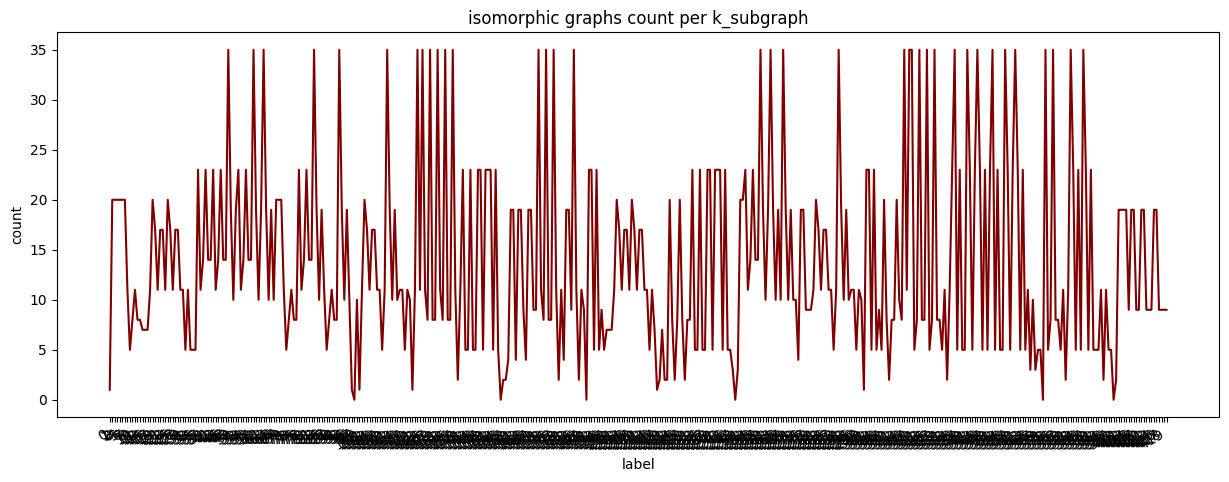

In [126]:
plot_map(k_subgraph_label_to_total_isomorphic_pairs_amount_map, 'label', 'count', 'isomorphic graphs count per k_subgraph')
# 6 k_subgraphs with no isomophic examples

In [127]:
for label, isomorphic_pairs_count in k_subgraph_label_to_total_isomorphic_pairs_amount_map.items():
    if isomorphic_pairs_count == 0:
        print(label)

97
155
189
248
370
398


In [128]:
target_k_subgraph_label = 97
target_graph = positive_examples_graphs[target_k_subgraph_label].g.copy() #G_sub.copy()
remove_isolated_nodes_from_graph(target_graph)
target_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7))

In [129]:
hidden_dim = 16
num_layers = 5
num_mlp_layers = 2
model_factory_func = lambda device: GraphCNN(num_layers=num_layers, num_mlp_layers = num_mlp_layers, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device)
solver_params["batch_size"] = 512 * 8
solver_params["k_update_plot"] = 1
solver_params["lr"] = 1e-1
solver_params["max_epochs"] = 200
current_trainer, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params, problem_params, graph_metric_nn_checkpoint_path=None)

In [130]:
current_trainer.train(processes_device_ids=processes_device_ids, use_existing_data_loaders=False, train_samples_list=used_train_samples_list, val_samples_list=[])


KeyboardInterrupt

